<a href="https://colab.research.google.com/github/charlyandral/OT/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # OT-GAN

 ## Importation des modules

In [0]:
# Packages de base
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers

# Transport
#import ot

# Graphiques



In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


 ## Importation des données

 La base de données MNIST est composée de respectivement 60000 et 10000 images dans sa partie "Train" et sa partie "Test". Chaque image représente un chiffre et est composée de 28 x 28 pixels.

 ### Base d'entrainement & Base de Test

 ## Paramètres

 ## Création du générateur

In [0]:


class cRelu(layers.Layer):

    def __init__(self, **kwargs):
        super(cRelu, self).__init__(**kwargs)

    def build(self, input_shape):
        super(cRelu, self).build(input_shape)

    def call(self, x):
        return tf.nn.crelu(x)

    def compute_output_shape(self, input_shape):
        """
        All axis of output_shape, except the last one,
        coincide with the input shape.
        The last one is twice the size of the corresponding input 
        as it's the axis along which the two relu get concatenated.
        """
        return (*input_shape[:-1], input_shape[-1]*2)



In [0]:


class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(
            FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config



In [0]:
def CreationGenerateur():

    # Initialisation
    model = tf.keras.Sequential()

    # Linear Reshape 100 -> 256x7x7
    model.add(layers.Dense(256*7*7, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    # 256x7x7 -> 128x7x7
    # stride = 1, activation = GLU
    model.add(FullGatedConv2D(128, kernel_size=(5, 5),
                              strides=(1, 1),
                              activation='linear',
                              padding='same',
                              use_bias=False))
    print(model.output_shape)

    # 128x7x7 -> 64x14x14
    model.add(layers.UpSampling2D())
    model.add(FullGatedConv2D(64, kernel_size=(5, 5), strides=(1, 1),
                              activation='linear',
                              padding='same',
                              use_bias=False))
    print(model.output_shape)

    model.add(layers.UpSampling2D())
    model.add(FullGatedConv2D(64, kernel_size=(5, 5),
                              strides=(1, 1),
                              activation='linear',
                              padding='same',
                              use_bias=False))
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5),
                                     strides=(1, 1),
                                     activation='tanh',
                                     padding='same',
                                     use_bias=False))
    print(model.output_shape)

    return model

    #model.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    # model.add(layers.Conv2D(,kernel_size=(5,5)), padding=)


 ### Initialisation et exemple

 Le bruit en input du générateur est initialisé par un vecteur aléatoire de taille 100 et de loi uniforme sur [-1,1].

 ## Création du discriminant

In [0]:


def CreationDiscriminateur():

    # Initialisation
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(50, kernel_size=(5, 5),
                            strides=(1, 1), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(cRelu())
    print(model.output_shape)

    model.add(layers.Conv2D(100, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(cRelu())
    print(model.output_shape)

    model.add(layers.Conv2D(100, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(cRelu())
    print(model.output_shape)

    model.add(layers.Flatten())
    print(model.output_shape)

    return model


 ### Initialisation
 On initialise les poids (arbitrairement) selon une loi Normale centrée d'écart-type 0.02

 ## Fonction de perte

 ## Implémentation de Sinkhorn

 Afin de pouvoir utiliser la différentiation automatique pour calculer le gradient de la perte, nous allons implémenter l'algorithme Sinkhorn en utilisant Tensorflow.

In [0]:


def Sinkhorn(M, m_size, reg, numItermax=1000, stopThr=1e-9):
    # we assume that no distances are null except those of the diagonal of distances

    a = tf.expand_dims(
        tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
    b = tf.expand_dims(
        tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

    # init data
    Nini = m_size[0]
    Nfin = m_size[1]

    u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
    v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

    K = tf.exp(-M / reg)  # (na, nb)

    Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

    cpt = tf.constant(0)
    err = tf.constant(1.0)

    def c(cpt, u, v, err): return tf.logical_and(
        cpt < numItermax, err > stopThr)

    def err_f1():
        # we can speed up the process by checking for the error only all the 10th iterations
        # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
        transp = u * (K * tf.squeeze(v))
        err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
        return err_

    def err_f2():
        return err

    def loop_func(cpt, u, v, err):
        # (nb, na) x (na, 1) = (nb, 1)
        KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)
        v = tf.divide(b, KtransposeU)  # (nb, 1)
        u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

        err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

        cpt = tf.add(cpt, 1)
        return cpt, u, v, err

    _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

    result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

    return result



In [0]:
def TransCost(X, Y):

    CX = tf.tile(tf.expand_dims(X, axis=1), [1, Y.shape[0], 1])
    CY = tf.tile(tf.expand_dims(Y, axis=0), [X.shape[0], 1, 1])
    CC = tf.add(tf.ones((X.shape[0], Y.shape[0])),
                tf.keras.losses.CosineSimilarity(axis=2)(CX, CY))
    return CC



In [0]:
# @tf.function
def WassersteinD(X, Y, Penalite):
    Y /= tf.sqrt(tf.reduce_sum(tf.square(Y), axis=1, keepdims=True))
    X /= tf.sqrt(tf.reduce_sum(tf.square(X), axis=1, keepdims=True))
    dist = []

    for i in range(X.shape[0]):
        dist.append(1. - tf.matmul(tf.expand_dims(X[i], 0), Y, transpose_b=True))
    CC = tf.concat(dist, 0)
    CSize = CC.shape
    W = Sinkhorn(CC, CSize, Penalite, numItermax=1000, stopThr=1e-9)
    return W



In [0]:
def loss_gen(X1, X2, Y1, Y2, Penalite):

    I1 = tf.add(WassersteinD(X1, Y1, Penalite), WassersteinD(X1, Y2, Penalite))
    I1 = tf.add(I1, WassersteinD(X2, Y1, Penalite))
    I1 = tf.add(I1, WassersteinD(X2, Y2, Penalite))
    I1 = tf.subtract(I1, tf.multiply(2., WassersteinD(X1, X2, Penalite)))
    L = tf.subtract(I1, tf.multiply(2., WassersteinD(Y1, Y2, Penalite)))

    return L

def loss_dis(X1, X2, Y1, Y2, Penalite):

    I1 = tf.add(WassersteinD(X1, Y1, Penalite), WassersteinD(X1, Y2, Penalite))
    I1 = tf.add(I1, WassersteinD(X2, Y1, Penalite))
    I1 = tf.add(I1, WassersteinD(X2, Y2, Penalite))
    I1 = tf.subtract(I1, tf.multiply(2., WassersteinD(X1, X2, Penalite)))
    L = tf.subtract(tf.multiply(2., WassersteinD(Y1, Y2, Penalite)),I1)

    return L



In [0]:
# n = 1000
# m = 10000
# X = tf.random.normal([n, m])
# Y = tf.random.normal([n, m])
# WassersteinD(X, Y, 1/50)



In [11]:
generator_optimizer = tf.keras.optimizers.Adam(3e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4,beta_1=0.5)
generator = CreationGenerateur()
discriminator = CreationDiscriminateur()



(None, 7, 7, 128)
(None, 14, 14, 64)
(None, 28, 28, 64)
(None, 28, 28, 1)
(None, 28, 28, 100)
(None, 14, 14, 200)
(None, 7, 7, 200)
(None, 9800)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


 ## Optimizers

 ## Entrainement

In [14]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images[train_labels == 1]
train_images = train_images.reshape(
    train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 200
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(BUFFER_SIZE).batch(2*BATCH_SIZE)


# # %%
i = 0
for _ in train_dataset:
    i += 1
print("nombre d'élements par batch :",i)



nombre d'élements par batch : 17


In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_gen(images):  # image de taille [2*BATCH_SIZE]
    temps1 = time.time()
    noise1 = tf.random.uniform([BATCH_SIZE, noise_dim], -1, 1)
    noise2 = tf.random.uniform([BATCH_SIZE, noise_dim], -1, 1)

    with tf.GradientTape() as gen_tape:
        generated_images_1 = generator(noise1, training=True)
        generated_images_2 = generator(noise2, training=True)


        real_output_1 = discriminator(images[:BATCH_SIZE], training=True)
        real_output_2 = discriminator(images[BATCH_SIZE:], training=True)

        fake_output_1 = discriminator(generated_images_1, training=True)
        fake_output_2 = discriminator(generated_images_2, training=True)

        temps4 = time.time()
        loss = loss_gen(real_output_1, real_output_2,
                    fake_output_1, fake_output_2,
                    Penalite=1/100)
    gradients_of_generator = gen_tape.gradient(
          loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))


@tf.function
def train_step_dis(images):  # image de taille [2*BATCH_SIZE]
    temps1 = time.time()
    noise1 = tf.random.uniform([BATCH_SIZE, noise_dim], -1, 1)
    noise2 = tf.random.uniform([BATCH_SIZE, noise_dim], -1, 1)

    with tf.GradientTape() as gen_tape:
        generated_images_1 = generator(noise1, training=True)
        generated_images_2 = generator(noise2, training=True)


        real_output_1 = discriminator(images[:BATCH_SIZE], training=True)
        real_output_2 = discriminator(images[BATCH_SIZE:], training=True)

        fake_output_1 = discriminator(generated_images_1, training=True)
        fake_output_2 = discriminator(generated_images_2, training=True)

        temps4 = time.time()
        loss = loss_dis(real_output_1, real_output_2,
                    fake_output_1, fake_output_2,
                    Penalite=1/100)
   
    gradients_of_discriminator = gen_tape.gradient(loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [0]:
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        start = time.time()
        i=0
        for image_batch in tqdm(dataset):
            if i%4 ==0:
              train_step_dis(image_batch)
            else:
              train_step_gen(image_batch)
            i+=1
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)



In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()



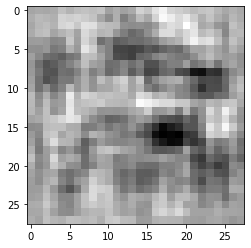

In [18]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')



In [0]:
train(train_dataset,100)